In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

100% 2.05G/2.06G [00:13<00:00, 188MB/s]
100% 2.06G/2.06G [00:13<00:00, 161MB/s]


In [ ]:
! unzip /content/chest-xray-covid19-pneumonia.zip

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras import layers
import numpy as np
import seaborn as sb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Directories with training pictures
train_corona_dir = os.path.join("/content/Data/train/COVID19")
train_normal_dir = os.path.join("/content/Data/train/NORMAL")
train_pneumonia_dir = os.path.join("/content/Data/train/PNEUMONIA")


train_corona_names = os.listdir(train_corona_dir)
train_normal_names = os.listdir(train_normal_dir)
train_pneumonia_names  = os.listdir(train_pneumonia_dir)

In [ ]:
print("train_corona", len(train_corona_names))
print("train_normal", len(train_normal_names))
print("train_pneumonia", len(train_pneumonia_names))

train_corona 460
train_normal 1266
train_pneumonia 3418


Covid Patients


<Figure size 1440x1440 with 0 Axes>

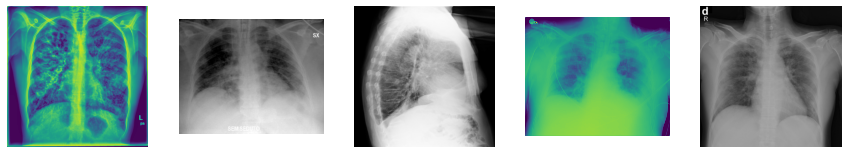

Normal Patients


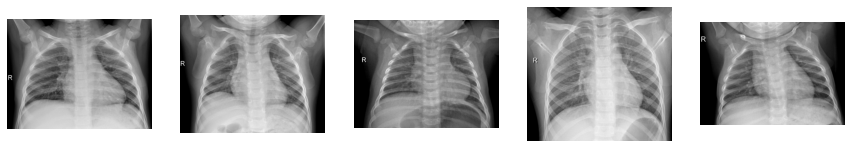

Pneumonia Patients


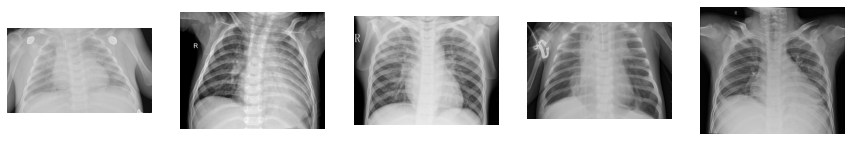

In [ ]:
# Visualize some training pictures
nrows = 5
ncols = 5
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 5

next_corona_pix = [os.path.join(train_corona_dir, fname) 
    for fname in train_corona_names[0:pic_index]]

next_normal_pix = [os.path.join(train_normal_dir, fname) 
    for fname in train_normal_names[0:pic_index]]

next_pnuemonia_pix = [os.path.join(train_pneumonia_dir, fname) 
    for fname in train_pneumonia_names[0:pic_index]]

fig=plt.figure(figsize=(15, 15))
print("Covid Patients")
for i,img_path in enumerate(next_corona_pix):
  fig.add_subplot(nrows, ncols, i+1)
  plt.axis("Off")
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()  

fig=plt.figure(figsize=(15, 15))
print("Normal Patients")
for i,img_path in enumerate(next_normal_pix):
  fig.add_subplot(nrows, ncols, i+1)
  plt.axis("Off")
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

fig=plt.figure(figsize=(15, 15))
print("Pneumonia Patients")
for i,img_path in enumerate(next_pnuemonia_pix):
  fig.add_subplot(nrows, ncols, i+1)
  plt.axis("Off")
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

In [ ]:
# Data Augmentation
IMAGE_SIZE = [150, 150]

train_path = '/content/Data/train'
valid_path = '/content/Data/test'

train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 128,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = 128,
                                            class_mode = 'categorical',
                                            shuffle = False)


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


## FIRST PART: WITHOUT TUNING THE PRE-TRAINED MODEL

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# number of classes
classes = 3

x = Flatten()(vgg.output)
prediction = Dense(classes, activation = 'softmax')(x)

# create a model 
VGG_model = Model(inputs = vgg.input, outputs = prediction)

# view the structure of the model
VGG_model.summary()

# the model what cost and optimization method to use
VGG_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=["accuracy"]
)



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
VGG_model.evaluate(test_set)

11/11 [==============================] - 26s 2s/step - loss: 1.0451 - accuracy: 0.2803


[1.045066237449646, 0.2802795171737671]

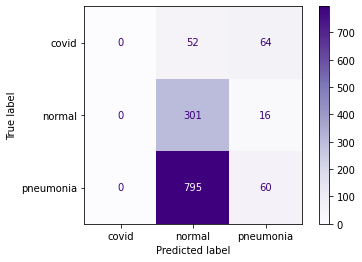

In [ ]:
# CONFUSION MATRIX
VGG_pred = VGG_model.predict(test_set)
VGG_pred = np.argmax(VGG_pred,axis=1)
VGG_test = test_set.classes

VGG_cm = confusion_matrix(VGG_test, VGG_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = VGG_cm, display_labels = ["covid", "normal", "pneumonia"])
disp.plot(cmap = plt.cm.Purples)
plt.show()

In [ ]:
# add preprocessing layer to the front of resnet
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False

# number of classes
classes = 3
  
x = Flatten()(resnet.output)
prediction = Dense(classes, activation='softmax')(x)

# create a model 
ResNet_model = Model(inputs=resnet.input, outputs=prediction)

# view the structure of the model
ResNet_model.summary()

# the model what cost and optimization method to use
ResNet_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=["accuracy"]
)


94781440/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizati

In [ ]:
ResNet_model.evaluate(test_set)

11/11 [==============================] - 28s 2s/step - loss: 1.4693 - accuracy: 0.0901


[1.4693206548690796, 0.09006211161613464]

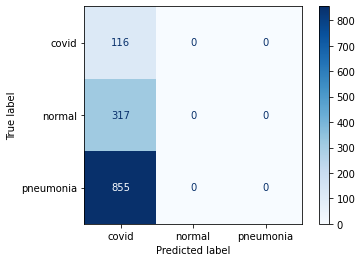

In [ ]:
# CONFUSION MATRIX
ResNet_pred = ResNet_model.predict(test_set)
ResNet_pred = np.argmax(ResNet_pred,axis=1)
ResNet_test = test_set.classes

ResNet_cm = confusion_matrix(ResNet_test, ResNet_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = ResNet_cm, display_labels = ["covid", "normal", "pneumonia"])
disp.plot(cmap = plt.cm.Blues)
plt.show()

### PART 2: TUNING THE PRE-TRAINED MODEL


In [ ]:
########################## VGG16 TRANSFER LEARNING ##########################
'''
  VGG16 
  TRANSFER 
  LEARNING
  WITH
  TUNING
'''
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# train existing weights of the last 3 layers
for layer in vgg.layers[:len(vgg.layers)-3]:
  layer.trainable = False

# number of classes
classes = 3

# our layers 
x = Flatten()(vgg.output)
x = layers.Dense(512, activation = "relu")(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

x = Flatten()(vgg.output)
x = layers.Dense(256, activation = "relu")(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

x = Flatten()(vgg.output)
x = layers.Dense(128, activation = "relu")(x)

prediction = Dense(classes, activation = 'softmax')(x)

# create a model object'''
VGG_model2 = Model(inputs = vgg.input, outputs = prediction)

# view the structure of the model
VGG_model2.summary()

# the model what cost and optimization method to use
VGG_model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=["accuracy"]
)

# fit the model
VGG_model_fit = VGG_model2.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
VGG_model2.evaluate(test_set)

11/11 [==============================] - 26s 2s/step - loss: 0.2076 - accuracy: 0.9169


[0.20760619640350342, 0.9169254899024963]

************* VGG16 Model With Tuning ******************


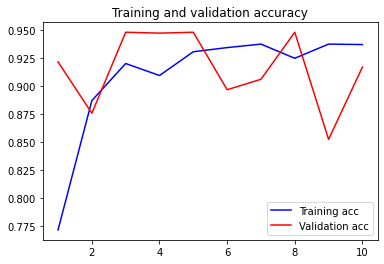

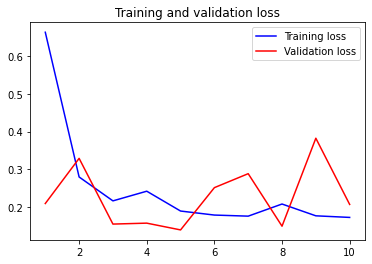

In [ ]:
# PLOT ACCURACY AND LOSS
acc = VGG_model_fit.history['accuracy']
val_acc = VGG_model_fit.history['val_accuracy']
loss = VGG_model_fit.history['loss']
val_loss = VGG_model_fit.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

print("************* VGG16 Model With Tuning ******************")
plt.show()

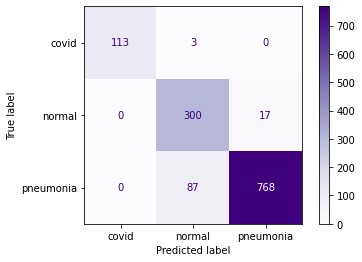

In [ ]:
# CONFUSION MATRIX
VGG_pred2 = VGG_model2.predict(test_set)
VGG_pred2 = np.argmax(VGG_pred2,axis=1)
VGG_test2 = test_set.classes

VGG_cm2 = confusion_matrix(VGG_test2, VGG_pred2)

VGG_cm2_disp = ConfusionMatrixDisplay(confusion_matrix = VGG_cm2, display_labels = ["covid", "normal", "pneumonia"])
VGG_cm2_disp.plot(cmap = plt.cm.Purples)
plt.show()

In [ ]:
########################## RESNET50 TRANSFER LEARNING ##########################
'''
  RESNET50 
  TRANSFER 
  LEARNING
  WITH
  TUNING
'''

# add preprocessing layer to the front of resnet
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers[:len(resnet.layers)-3]:
  layer.trainable = False

# number of classes
classes = 3
  
# our layers 
x = Flatten()(resnet.output)
x = layers.Dense(512, activation = "relu")(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

x = Flatten()(resnet.output)
x = layers.Dense(256, activation = "relu")(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

x = Flatten()(resnet.output)
x = layers.Dense(128, activation = "relu")(x)

prediction = Dense(classes, activation = 'softmax')(x)

# create a model object
ResNet_model = Model(inputs=resnet.input, outputs=prediction)

# view the structure of the model
ResNet_model.summary()

# the model what cost and optimization method to use
ResNet_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=["accuracy"]
)

# fit the model
ResNet_model_fit = ResNet_model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
ResNet_model.evaluate(test_set)

11/11 [==============================] - 29s 2s/step - loss: 0.5447 - accuracy: 0.7849


[0.5446959733963013, 0.784937858581543]

************* ResNet50 Model With Tuning ******************


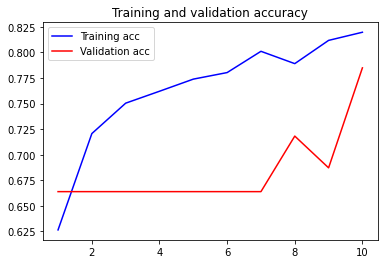

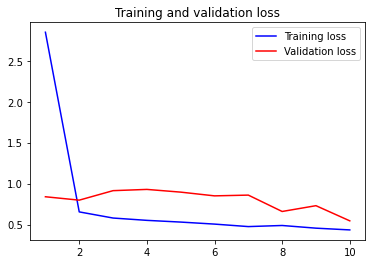

In [ ]:
# PLOT ACCURACY AND LOSS 
acc = ResNet_model_fit.history['accuracy']
val_acc = ResNet_model_fit.history['val_accuracy']
loss = ResNet_model_fit.history['loss']
val_loss = ResNet_model_fit.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

print("************* ResNet50 Model With Tuning ******************")
plt.show()

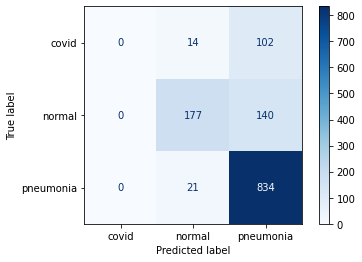

In [ ]:
# CONFUSSION MATRIX
ResNet2_pred = ResNet_model.predict(test_set)
ResNet2_pred = np.argmax(ResNet2_pred,axis=1)
ResNet2_test = test_set.classes

ResNet_cm_2 = confusion_matrix(ResNet2_test, ResNet2_pred)

ResNet_cm_2_disp = ConfusionMatrixDisplay(confusion_matrix = ResNet_cm_2, display_labels = ["covid", "normal", "pneumonia"])
ResNet_cm_2_disp.plot(cmap = plt.cm.Blues)
plt.show()

### EXTRA PART: BUILD OUR OWN CNN MODEL

In [ ]:
model_cnn = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_cnn.summary()

model_cnn.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=["accuracy"]
)


# fit the model
model_cnn_fit = model_cnn.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       7

In [ ]:
model_cnn.evaluate(test_set)

11/11 [==============================] - 25s 2s/step - loss: 0.3909 - accuracy: 0.8160


[0.3908790946006775, 0.8159937858581543]

************* CNN Model With 0.2 Dropout ******************


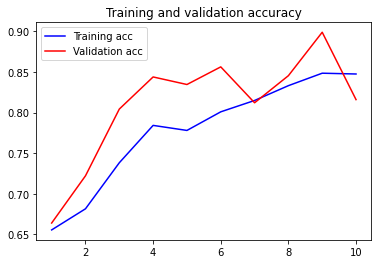

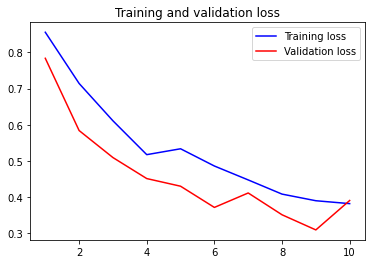

In [ ]:
# PLOT ACCURACY AND LOSS
acc = model_cnn_fit.history['accuracy']
val_acc = model_cnn_fit.history['val_accuracy']
loss = model_cnn_fit.history['loss']
val_loss = model_cnn_fit.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

print("************* CNN Model With 0.2 Dropout ******************")
plt.show()

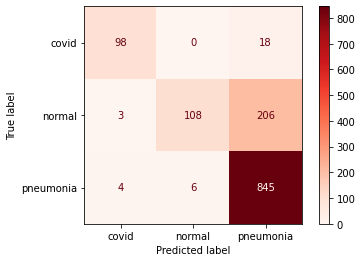

In [ ]:
# CONFUSSION MATRIX
CNN_pred = model_cnn.predict(test_set)
CNN_pred = np.argmax(CNN_pred,axis=1)
CNN_test = test_set.classes

CNN_cm = confusion_matrix(CNN_test, CNN_pred)

CNN_cm_disp = ConfusionMatrixDisplay(confusion_matrix = CNN_cm, display_labels = ["covid", "normal", "pneumonia"])
CNN_cm_disp.plot(cmap = plt.cm.Reds)
plt.show()